## Objective

Use Random Forests, see if $R^2$ improves from 0.56.

In [58]:
from __future__ import division
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 20, 5
warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_style("whitegrid")
sns.set_context("poster")

import os, sys
sys.path.append(os.path.join(os.path.dirname('.'), "../preprocessing"))
from helper_functions import dummify_cols_and_baselines, make_alphas, remove_outliers_by_type, transform_school

In [59]:
df_orig = pd.read_pickle('../data/data_from_remove_from_dataset.pkl')
df_orig.shape

(516406, 40)

## Removing outliers

A standard procedure is to remove values further than 3 standard deviations from the mean. Since I have so many low values and some very high values, I anecdotally think that the low values are very likely to be true, and the high values not so much.

So, I will remove values further than 3 SDs from the median, by type.

Ideally, I would take into account the time dimension. I would like to do so given more time.

In [60]:
df1 = remove_outliers_by_type(df_orig, y_col='COMPLETION_HOURS_LOG_10')
df1.shape

(508653, 40)

I'm removing ~1.5% of my rows.

## Transformations

In [61]:
df2 = transform_school(df1)
df2.shape

(508653, 40)

## Only Recycling Cart Return TYPE

In [62]:
df3 = df2[df2.TYPE == 'Needle Pickup'].drop('TYPE', axis=1)
df3.shape

(1683, 39)

## Choosing columns

In [63]:
cols_orig_dataset = ['COMPLETION_HOURS_LOG_10', 'SubmittedPhoto', 'Property_Type', 'Source', 'neighborhood_from_zip']
cols_census = ['race_white',
     'race_black',
     'race_asian',
     'race_hispanic',
     'race_other',
     'poverty_pop_below_poverty_level',
     'earned_income_per_capita',
     'poverty_pop_w_public_assistance',
     'poverty_pop_w_food_stamps',
     'poverty_pop_w_ssi',
     'school',
     'school_std_dev',
     'housing',
     'housing_std_dev',
     'bedroom',
     'bedroom_std_dev',
     'value',
     'value_std_dev',
     'rent',
     'rent_std_dev',
     'income',
     'income_std_dev']
cols_engineered = ['queue_wk', 'queue_wk_open', 'is_description']

In [64]:
df4 = df3[cols_orig_dataset + cols_census + cols_engineered]

## Dummify

In [65]:
cols_to_dummify = df4.dtypes[df4.dtypes == object].index
cols_to_dummify

Index([u'Property_Type', u'Source', u'neighborhood_from_zip', u'housing'], dtype='object')

In [66]:
df_dummified, baseline_cols = dummify_cols_and_baselines(df4, cols_to_dummify)

other is baseline 0 4
Twitter is baseline 1 4
West Roxbury is baseline 2 4
rent is baseline 3 4


In [26]:
df_dummified.shape

(1986, 46)

## Running model

In [67]:
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    df_dummified.drop('COMPLETION_HOURS_LOG_10', axis=1), 
    df_dummified.COMPLETION_HOURS_LOG_10, 
    test_size=0.2, 
    random_state=300
)

In [82]:
cols_multicollinear = [u'race_white', u'race_black', u'race_hispanic', u'neighborhood_from_zip_Dorchester', u'earned_income_per_capita']

X_train, X_test, y_train, y_test = train_test_split(
    df_dummified.drop(['COMPLETION_HOURS_LOG_10'] + cols_multicollinear, axis=1), 
    df_dummified.COMPLETION_HOURS_LOG_10, 
    test_size=0.2, 
    random_state=300
)

In [69]:
pipe = make_pipeline(RandomForestRegressor())

In [70]:
cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=300)

In [86]:
# I wanted to use oob_score but need for loop
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
# decided that with mulitple folds, each fold had similar performance, so went with k=1

params = {'randomforestregressor__max_depth': [50, 100, 150], 
          'randomforestregressor__min_samples_split': [.01, .03, .05, .10],
          'randomforestregressor__min_samples_leaf': [.01, .03, .05, .10],
          'randomforestregressor__max_features': [7, 15, 35, 45], # 46 total
          'randomforestregressor__n_estimators': [300, 400, 500]}

params = {'randomforestregressor__max_depth': [25, 50, 60], 
          'randomforestregressor__min_samples_split': [0.001, 0.003, .01],
          'randomforestregressor__min_samples_leaf': [0.001, 0.003, .01],
          'randomforestregressor__max_features': ['auto'], # for some reason 45 best out of [7, 15, 35, 45]
          'randomforestregressor__n_estimators': [300]}

params = {'randomforestregressor__max_depth': [50], 
          'randomforestregressor__min_samples_split': [.01],
          'randomforestregressor__min_samples_leaf': [.01],
          'randomforestregressor__max_features': [0.4, 'sqrt', 'auto'], # for some reason 45 best out of [7, 15, 35, 45]
          'randomforestregressor__n_estimators': [1, 10, 100, 300]}

params = {'randomforestregressor__max_depth': [2], 
          'randomforestregressor__min_samples_split': [.05],
          'randomforestregressor__min_samples_leaf': [.05],
          'randomforestregressor__max_features': [None], # for some reason 45 best out of [7, 15, 35, 45]
          'randomforestregressor__n_estimators': [1]}

model = GridSearchCV(pipe, param_grid=params, n_jobs=1, cv=cv, verbose=1)
model.fit(X_train, y_train)
results = pd.DataFrame(model.cv_results_).T

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [87]:
model.best_params_

{'randomforestregressor__max_depth': 2,
 'randomforestregressor__max_features': None,
 'randomforestregressor__min_samples_leaf': 0.05,
 'randomforestregressor__min_samples_split': 0.05,
 'randomforestregressor__n_estimators': 1}

In [88]:
model.best_score_

0.38148193417994664

In [55]:
X_train.shape

(1588, 45)

In [57]:
X_train.head(1).T

,643078
SubmittedPhoto,False
race_white,0.962659
race_black,0
race_asian,0.012696
race_hispanic,0.0246453
race_other,0
poverty_pop_below_poverty_level,0.0401284
earned_income_per_capita,64372
poverty_pop_w_public_assistance,0
poverty_pop_w_food_stamps,0


In [54]:
results.iloc[2:9]

,0,1,2,3,4,5,6,7,8,9,10,11
mean_test_score,0.678319,0.753082,0.767649,0.766937,0.413059,0.64115,0.663653,0.669189,0.721175,0.766408,0.780556,0.778119
mean_train_score,0.756756,0.823408,0.833619,0.833002,0.501109,0.712737,0.73508,0.738212,0.788973,0.842715,0.849293,0.849256
param_randomforestregressor__max_depth,50,50,50,50,50,50,50,50,50,50,50,50
param_randomforestregressor__max_features,0.4,0.4,0.4,0.4,sqrt,sqrt,sqrt,sqrt,auto,auto,auto,auto
param_randomforestregressor__min_samples_leaf,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
param_randomforestregressor__min_samples_split,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
param_randomforestregressor__n_estimators,1,10,100,300,1,10,100,300,1,10,100,300


In [52]:
results.iloc[2:9]

,0,1,2,3
mean_test_score,0.706575,0.767829,0.780011,0.777775
mean_train_score,0.793392,0.842632,0.848664,0.849464
param_randomforestregressor__max_depth,50,50,50,50
param_randomforestregressor__max_features,auto,auto,auto,auto
param_randomforestregressor__min_samples_leaf,0.01,0.01,0.01,0.01
param_randomforestregressor__min_samples_split,0.01,0.01,0.01,0.01
param_randomforestregressor__n_estimators,1,10,100,300


In [38]:
results = pd.DataFrame(model3.cv_results_).T
results

,0,1,2
mean_fit_time,460.889,490.748,488.439
mean_score_time,2.81586,3.07321,3.01894
mean_test_score,0.628366,0.624944,0.624703
mean_train_score,0.916543,0.940756,0.94142
param_randomforestregressor__max_depth,50,75,85
param_randomforestregressor__n_estimators,30,30,30
param_randomforestregressor__oob_score,True,True,True
params,"{u'randomforestregressor__max_depth': 50, u'ra...","{u'randomforestregressor__max_depth': 75, u'ra...","{u'randomforestregressor__max_depth': 85, u'ra..."
rank_test_score,1,2,3
split0_test_score,0.628366,0.624944,0.624703


In [33]:
results = pd.DataFrame(model2.cv_results_).T
results

,0,1,2
mean_fit_time,59.176,135.95,210.871
mean_score_time,1.28531,1.34715,1.4439
mean_test_score,0.46555,0.464261,0.464148
mean_train_score,0.473085,0.471913,0.47176
param_randomforestregressor__max_depth,10,10,10
param_randomforestregressor__n_estimators,10,25,40
param_randomforestregressor__oob_score,True,True,True
params,"{u'randomforestregressor__max_depth': 10, u'ra...","{u'randomforestregressor__max_depth': 10, u'ra...","{u'randomforestregressor__max_depth': 10, u'ra..."
rank_test_score,1,2,3
split0_test_score,0.46555,0.464261,0.464148


In [20]:
results = pd.DataFrame(model.cv_results_).T
results

,0,1,2,3,4,5,6,7,8
mean_fit_time,279.679,538.562,781.369,877.744,1679.15,2430.63,844.865,1641.91,2462
mean_score_time,1.55904,1.91368,2.45124,4.53693,7.57992,10.2313,4.53368,7.26755,10.0672
mean_test_score,0.46469,0.464717,0.46495,0.63119,0.63385,0.634941,0.631045,0.633741,0.634933
mean_train_score,0.472256,0.472292,0.472518,0.944207,0.946224,0.946885,0.944177,0.946196,0.946873
param_randomforestregressor__max_depth,10,10,10,100,100,100,None,None,None
param_randomforestregressor__n_estimators,50,100,150,50,100,150,50,100,150
params,"{u'randomforestregressor__max_depth': 10, u'ra...","{u'randomforestregressor__max_depth': 10, u'ra...","{u'randomforestregressor__max_depth': 10, u'ra...","{u'randomforestregressor__max_depth': 100, u'r...","{u'randomforestregressor__max_depth': 100, u'r...","{u'randomforestregressor__max_depth': 100, u'r...","{u'randomforestregressor__max_depth': None, u'...","{u'randomforestregressor__max_depth': None, u'...","{u'randomforestregressor__max_depth': None, u'..."
rank_test_score,9,8,7,5,3,1,6,4,2
split0_test_score,0.46469,0.464717,0.46495,0.63119,0.63385,0.634941,0.631045,0.633741,0.634933
split0_train_score,0.472256,0.472292,0.472518,0.944207,0.946224,0.946885,0.944177,0.946196,0.946873


## Conclusion

Random Forests, unsurprisingly, beats Decision Tree + pruning and Linear Regression with L1 Lasso regularization. The best performing model, with $R^2=0.64$, had 150 trees and a depth of 100.

The $R^2$ starts to asymptote around 50 trees and 30 depth. I will use this as my best model to make predictions.

In [46]:
model3.best_score_

0.62836648105953374

In [16]:
model.best_score_

0.63023310082171957

In [16]:
model.best_score_

0.63494073187298072

In [17]:
model.score(X_test, y_test)

0.64116203270827277

In [54]:
y_pred = model.predict(X_test)

In [56]:
pd.Series(y_pred).describe()

count    101731.000000
mean          1.710346
std           0.938206
min          -2.820321
25%           1.145173
50%           1.905054
75%           2.334531
max           4.325803
dtype: float64

In [55]:
y_test.describe()

count    101731.000000
mean          1.717758
std           1.119753
min          -2.857332
25%           1.353593
50%           1.865962
75%           2.375708
max           4.582340
Name: COMPLETION_HOURS_LOG_10, dtype: float64

In [58]:
mean_squared_error(y_test, y_pred)**0.5

0.67076351996732153

In [59]:
y_pred3 = model3.predict(X_test)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  1

In [60]:
mean_squared_error(y_test, y_pred3)**0.5

0.67614465610813312

In [51]:
model3.best_estimator_.steps[-1][-1].oob_score_

0.6177917198912124

In [47]:
model3.best_params_

{'randomforestregressor__max_depth': 50,
 'randomforestregressor__n_estimators': 30,
 'randomforestregressor__oob_score': True}

In [18]:
model.best_params_

{'randomforestregressor__max_depth': 100,
 'randomforestregressor__n_estimators': 150}

In [14]:
results = pd.DataFrame(model.cv_results_).T
results

,0,1,2,3,4,5,6,7,8
mean_fit_time,279.679,538.562,781.369,877.744,1679.15,2430.63,844.865,1641.91,2462
mean_score_time,1.55904,1.91368,2.45124,4.53693,7.57992,10.2313,4.53368,7.26755,10.0672
mean_test_score,0.46469,0.464717,0.46495,0.63119,0.63385,0.634941,0.631045,0.633741,0.634933
mean_train_score,0.472256,0.472292,0.472518,0.944207,0.946224,0.946885,0.944177,0.946196,0.946873
param_randomforestregressor__max_depth,10,10,10,100,100,100,None,None,None
param_randomforestregressor__n_estimators,50,100,150,50,100,150,50,100,150
params,"{u'randomforestregressor__max_depth': 10, u'ra...","{u'randomforestregressor__max_depth': 10, u'ra...","{u'randomforestregressor__max_depth': 10, u'ra...","{u'randomforestregressor__max_depth': 100, u'r...","{u'randomforestregressor__max_depth': 100, u'r...","{u'randomforestregressor__max_depth': 100, u'r...","{u'randomforestregressor__max_depth': None, u'...","{u'randomforestregressor__max_depth': None, u'...","{u'randomforestregressor__max_depth': None, u'..."
rank_test_score,9,8,7,5,3,1,6,4,2
split0_test_score,0.46469,0.464717,0.46495,0.63119,0.63385,0.634941,0.631045,0.633741,0.634933
split0_train_score,0.472256,0.472292,0.472518,0.944207,0.946224,0.946885,0.944177,0.946196,0.946873


In [30]:
results.T[['param_randomforestregressor__max_depth', 'param_randomforestregressor__n_estimators', 'mean_test_score']]

,param_randomforestregressor__max_depth,param_randomforestregressor__n_estimators,mean_test_score
0,10,50,0.46469
1,10,100,0.464717
2,10,150,0.46495
3,100,50,0.63119
4,100,100,0.63385
5,100,150,0.634941
6,None,50,0.631045
7,None,100,0.633741
8,None,150,0.634933


In [42]:
sns.regplot(
    x='param_randomforestregressor__max_depth',
    y='mean_test_score',
    data=results.T[['param_randomforestregressor__max_depth', 'mean_test_score']], 
    fit_reg=False
);

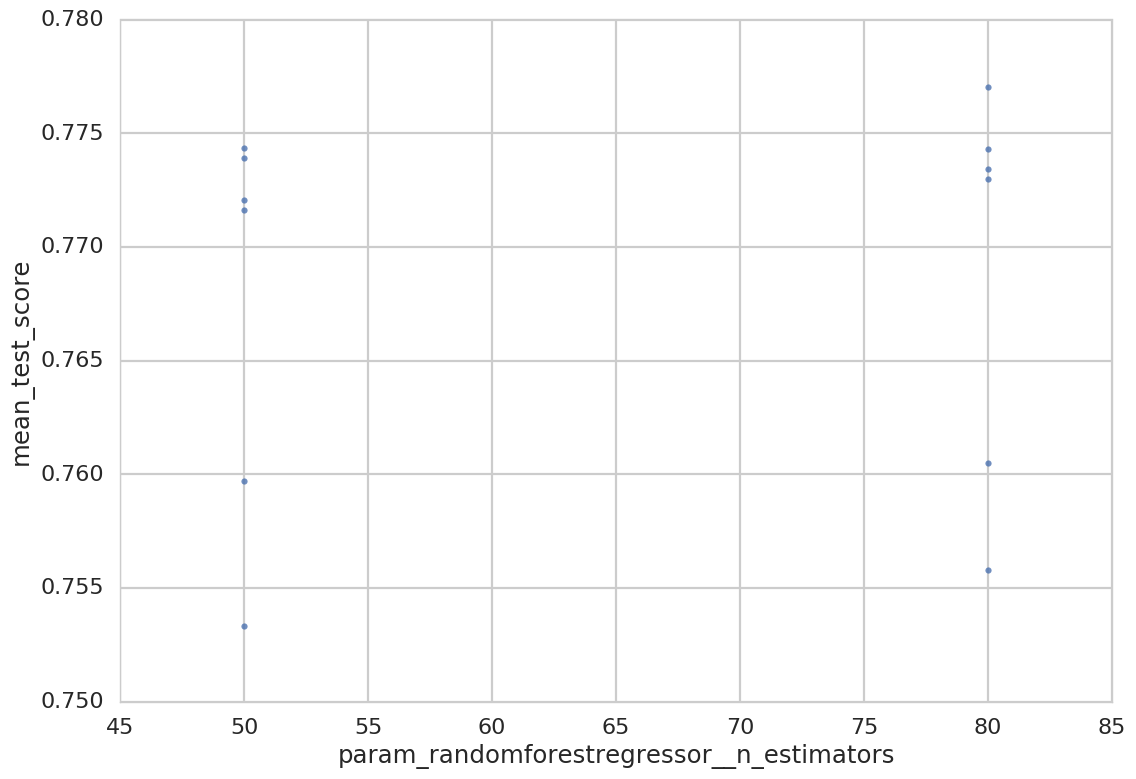

In [36]:
sns.regplot(
    x='param_randomforestregressor__n_estimators',
    y='mean_test_score',
    data=results.T[['param_randomforestregressor__n_estimators', 'mean_test_score']], 
    fit_reg=False
);

## Variable Importance Table

To learn which nodes most affect the completion time

In [17]:
feature_importances = pd.np.argsort(model.best_estimator_.steps[0][-1].feature_importances_)
features = list(df_dummified.drop('COMPLETION_HOURS_LOG_10', axis=1).columns[feature_importances[-1:-11:-1]])
pd.DataFrame({'top ten features': features})

AttributeError: 'StandardScaler' object has no attribute 'feature_importances_'

In [ ]:
n = 10 # top 10 features

importances = model.best_estimator_.steps[0][-1].feature_importances_[:n]
std = pd.np.std([tree.feature_importances_ for tree in model.best_estimator_.steps[0][-1]], axis=0)
indices = pd.np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(n):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()